## Import

In [1]:
import pandas as pd
import numpy as np
import gc
import swifter
from tqdm.auto import tqdm
import math
import dask.dataframe as dd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import random

## Data Preperation

In [2]:
#!rm data/training -r
#!rm data/test -r

rm: cannot remove 'data/training': No such file or directory
rm: cannot remove 'data/test': No such file or directory


### Load Image-Weather Data

In [3]:
df_img_weather = dd.read_csv("data/img_weather_2007_2012.csv")
print(df_img_weather.shape)
df_img_weather.head(2)

(Delayed('int-cefbbc92-d31d-47ea-a5cf-275ba4d48097'), 12)


,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP
0,3873511228,2008-04-04,30,-90,722310,76.8,70.9,1012.7,9.8,10.6,0.0,999.9
1,2402567418,2008-04-04,30,-90,722310,76.8,70.9,1012.7,9.8,10.6,0.0,999.9


In [4]:
df_labels = dd.read_csv('data/labels-all.csv', usecols = ['Image','Label'])
df_labels.head(2)

,Image,Label
0,4650143588.jpg,0
1,4648427466.jpg,1


In [5]:
def get_file_id(filename):
    return np.int64(filename.split('.')[0])

#get_file_id('234234.txt')

234234

### Filter for outdoor images

In [6]:
df_labels['file_id'] = df_labels['Image'].apply(get_file_id, meta=('file_id','int64'))
df_labels.head(2)

,Image,Label,file_id
0,4650143588.jpg,0,4650143588
1,4648427466.jpg,1,4648427466


In [7]:
outdoor_images = df_labels[df_labels['Label']==1]
print(outdoor_images.shape)
outdoor_images.head(2)

(Delayed('int-f7f918fc-d81a-46e0-ba4d-5d2067275009'), 3)


,Image,Label,file_id
1,4648427466.jpg,1,4648427466
3,4578410260.jpg,1,4578410260


In [8]:
df_img_weather = df_img_weather[df_img_weather['id'].isin(outdoor_images['file_id'].compute().values)]
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9


### Temperature

(-20.0, 120.0)

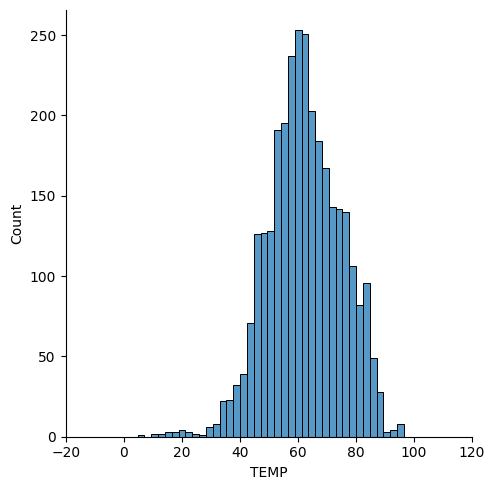

In [9]:
sns.displot(df_img_weather, x="TEMP")
plt.xlim(-20,120)

In [10]:
def get_temperature_class(temperature):
    if temperature== 9999.9:
        return 99
    elif temperature>75:
        return 0
    elif 75>=temperature>65:
        return 1
    elif 65>=temperature>50:
        return 2
    else:
        return 3

In [11]:
df_img_weather['TEMP_class'] = df_img_weather['TEMP'].apply(get_temperature_class, meta=('TEMP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9,2
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9,1
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9,2


(0.0, 5.0)

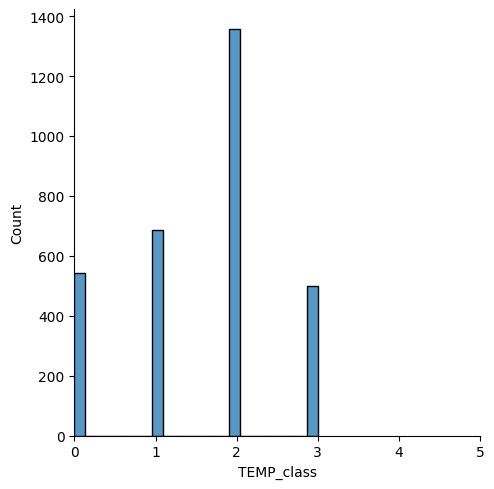

In [12]:
sns.displot(df_img_weather, x="TEMP_class")
plt.xlim(0,5)

### Wind Speed

(0.0, 40.0)

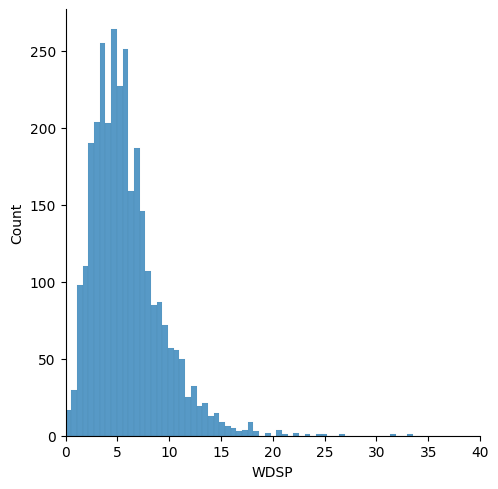

In [13]:
sns.displot(df_img_weather, x="WDSP")
plt.xlim(0,40)

In [14]:
def get_wind_speed_class(speed):
    if speed==999.9:
        return 99
    elif speed>8:
        return 0
    elif 8>=speed>4:
        return 1
    else:
        return 2

In [15]:
df_img_weather['WDSP_class'] = df_img_weather['WDSP'].apply(get_wind_speed_class, meta=('WDSP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9,2,2
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9,1,1
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9,2,0


(0.0, 5.0)

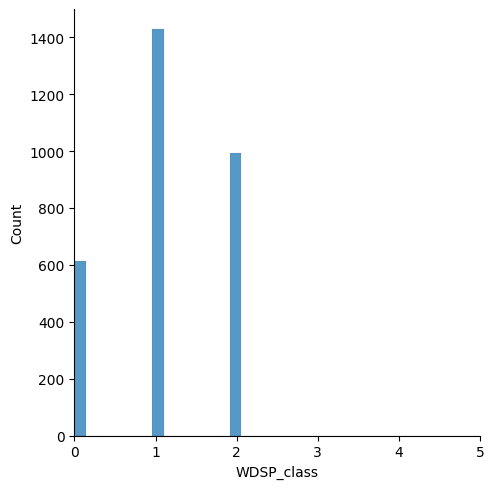

In [16]:
sns.displot(df_img_weather, x="WDSP_class")
plt.xlim(0,5)

### Dew Point

(0.0, 100.0)

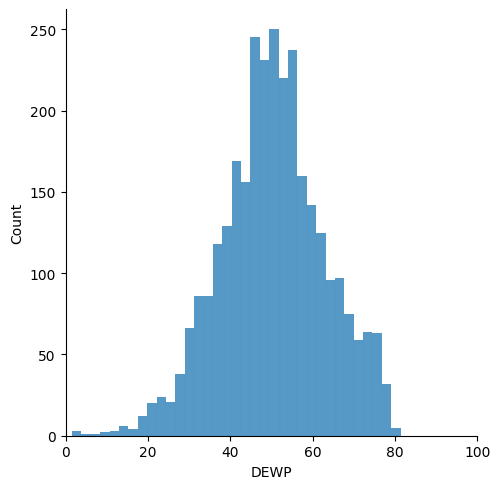

In [17]:
sns.displot(df_img_weather, x="DEWP")
plt.xlim(0,100)

In [18]:
def get_dewp_class(dewp):
    if dewp==9999.9:
        return 99
    elif dewp>60:
        return 0
    elif 60>=dewp>45:
        return 1
    else:
        return 2

In [19]:
df_img_weather['DEWP_class'] = df_img_weather['DEWP'].apply(get_dewp_class, meta=('DEWP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9,2,2,1
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9,1,1,1
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9,2,0,2


(0.0, 5.0)

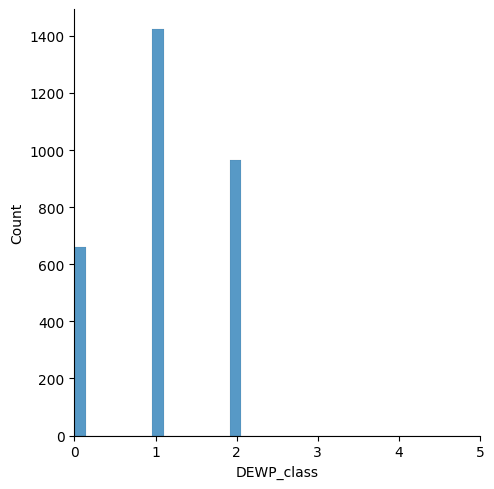

In [20]:
sns.displot(df_img_weather, x="DEWP_class")
plt.xlim(0,5)

### Visibility

(0.0, 40.0)

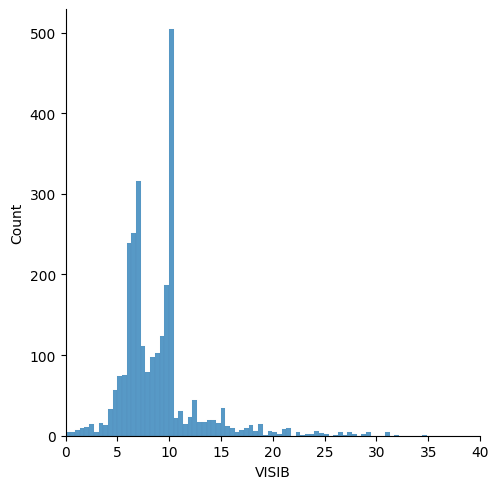

In [21]:
sns.displot(df_img_weather, x="VISIB")
plt.xlim(0,40)

In [22]:
def get_visib_class(visib):
    if visib==999.9:
        return 99
    elif visib>8:
        return 0
    elif 8>=visib>6:
        return 1
    else:
        return 2

In [23]:
df_img_weather['VISIB_class'] = df_img_weather['VISIB'].apply(get_visib_class, meta=('VISIB_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class,VISIB_class
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9,2,2,1,2
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9,1,1,1,1
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9,2,0,2,0


(0.0, 5.0)

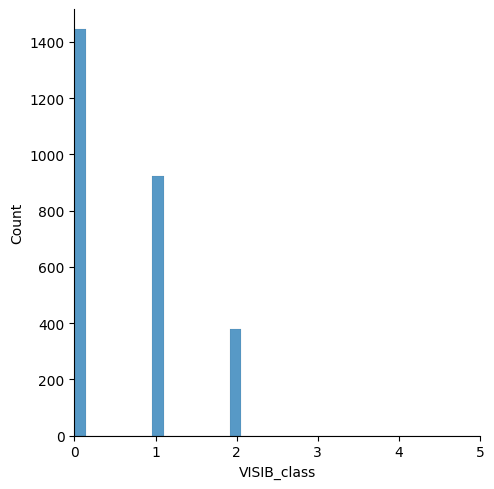

In [24]:
sns.displot(df_img_weather, x="VISIB_class")
plt.xlim(0,5)

### Prepare Images

In [25]:
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class,VISIB_class
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9,2,2,1,2
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9,1,1,1,1
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9,2,0,2,0


In [26]:
# Declare class groups and labels
class_groups = ['TEMP_class','WDSP_class', 'DEWP_class', 'VISIB_class']
class_groups_labels = [
    [0,1,2,3],
    [0,1,2],
    [0,1,2],
    [0,1,2]
]         

In [27]:
# Create Empty directory for training and test images
if not os.path.isdir(f"data/training"):
    os.mkdir(f"data/training")
if not os.path.isdir(f"data/test"):
    os.mkdir(f"data/test")
    
for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    if not os.path.isdir(f"data/training/{class_group}"): 
        os.mkdir(f"data/training/{class_group}")
    if not os.path.isdir(f"data/test/{class_group}"): 
        os.mkdir(f"data/test/{class_group}")        
    
    for label in class_group_labels:
        if not os.path.isdir(f"data/training/{class_group}/{label}"): 
            os.mkdir(f"data/training/{class_group}/{label}")
        if not os.path.isdir(f"data/test/{class_group}/{label}"): 
            os.mkdir(f"data/test/{class_group}/{label}")  

In [28]:
COPIED_FILES = []
SKIPPED_FILES = []
def copy_image_to_training(img_id, class_group, label):
    if label==99:
        return
    if os.path.isfile(f"data/download/1/{img_id}.jpg"):
        shutil.copy(f"data/download/1/{img_id}.jpg", f"data/training/{class_group}/{label}/{img_id}.jpg")
        COPIED_FILES.append(f"data/download/1/{img_id}.jpg")
    else:
        SKIPPED_FILES.append(f"data/download/1/{img_id}.jpg")
        

In [29]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'TEMP_class', x['TEMP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

1697 1388


In [30]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'WDSP_class', x['WDSP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

1673 1362


In [31]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'DEWP_class', x['DEWP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

1680 1371


In [32]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'VISIB_class', x['VISIB_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

1503 1243


In [34]:
#Copy 20% images for testing
for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    for label in class_group_labels:
        print(f"Copying {class_group}/{label}")
        files = [f for f in os.listdir(f"data/training/{class_group}/{label}") if os.path.isfile(os.path.join(f"data/training/{class_group}/{label}", f))]
        val_size = len(files)//(100//20)
        val_files = random.sample(files, val_size)
        for file in tqdm(val_files):
            #TODO: Move the file instead of copy
            shutil.copy(f"data/training/{class_group}/{label}/{file}", f"data/test/{class_group}/{label}/{file}")
        


Copying TEMP_class/0


  0%|          | 0/61 [00:00<?, ?it/s]

Copying TEMP_class/1


  0%|          | 0/74 [00:00<?, ?it/s]

Copying TEMP_class/2


  0%|          | 0/139 [00:00<?, ?it/s]

Copying TEMP_class/3


  0%|          | 0/64 [00:00<?, ?it/s]

Copying WDSP_class/0


  0%|          | 0/70 [00:00<?, ?it/s]

Copying WDSP_class/1


  0%|          | 0/156 [00:00<?, ?it/s]

Copying WDSP_class/2


  0%|          | 0/108 [00:00<?, ?it/s]

Copying DEWP_class/0


  0%|          | 0/73 [00:00<?, ?it/s]

Copying DEWP_class/1


  0%|          | 0/146 [00:00<?, ?it/s]

Copying DEWP_class/2


  0%|          | 0/116 [00:00<?, ?it/s]

Copying VISIB_class/0


  0%|          | 0/156 [00:00<?, ?it/s]

Copying VISIB_class/1


  0%|          | 0/101 [00:00<?, ?it/s]

Copying VISIB_class/2


  0%|          | 0/42 [00:00<?, ?it/s]